In [4]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim 
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os

SEED = 1234

import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
data_dir = 'TestSet'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
    

loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

Running on device: cuda:1


# Model

In [6]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

resnet.load_state_dict(torch.load('GeorgiaTech-TestDataset_StateDict.pth'))

<All keys matched successfully>

# Test DataLoader

In [7]:
trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))

test_loader = DataLoader( 
    dataset,
    num_workers=workers,
    batch_size=1,
)

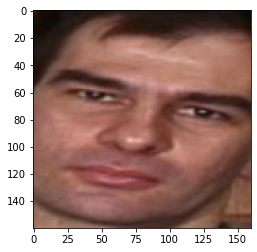

In [8]:
x, y = next(iter(test_loader))

import torchvision.utils as utils
import matplotlib.pyplot as plt
plt.imshow(np.transpose(utils.make_grid(x.detach().cpu(), padding=2, normalize=True),(1,2,0)))

# Processing

In [9]:
import cv2
import mediapipe as mp
import numpy as np
from math import hypot
from imutils import paths
import os

In [10]:
# Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh() 

In [11]:
def get_landmarks(location, frame_patch_width, frame_patch_height, global_patch_width, facial_landmarks):

     # Nose Co-ordinates
        if location == 'Nose':
            center = (facial_landmarks.landmark[195].x * frame_patch_width, facial_landmarks.landmark[195].y * frame_patch_height)


            # patch_width = int(hypot(left_point[0] - right_point[0],
            #                     left_point[1] - right_point[1]))

            patch_width = global_patch_width
            patch_height = int(patch_width)                      

            top_left = (int(center[0] - patch_width / 2),
                            int(center[1] - patch_height /2))

        # EyeBrow Coordinates
        if location == 'Eyebrow':
            center = (facial_landmarks.landmark[69].x * frame_patch_width, facial_landmarks.landmark[69].y * frame_patch_height)



            patch_width = global_patch_width
            patch_height = int(patch_width)                      

            top_left = (int(center[0] - patch_width / 2),
                            int(center[1] - patch_height /2))


        # Chin Coordinates
        if location == 'Chin':
            center = (facial_landmarks.landmark[199].x * frame_patch_width, facial_landmarks.landmark[199].y * frame_patch_height)


            patch_width = global_patch_width
            patch_height = int(patch_width)                      

            top_left = (int(center[0] - patch_width / 2),
                            int(center[1] - patch_height /2))


            
        # Cheek Coordinates
        if location == 'Cheek':
            center = (facial_landmarks.landmark[205].x * frame_patch_width, facial_landmarks.landmark[205].y * frame_patch_height)

            patch_width = global_patch_width
            patch_height = int(patch_width)                      

            top_left = (int(center[0] - patch_width / 2),
                            int(center[1] - patch_height /2))
      
            
        return patch_width, patch_height, top_left

In [12]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [13]:
aligned = []
x_aligned, prob = mtcnn(frame, return_prob=True)
aligned.append(x_aligned)

NameError: name 'frame' is not defined

# PGD - Projected Gradient Descent Attack

In [46]:
# PGD Attack
# PROJECTED GRADIENT DESCENT
import torch
import torch.nn as nn

def pgd_attack(model, images, labels, eps=1, alpha=2/255, iters=40) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
                
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images, eta


CPU times: user 5.29 s, sys: 0 ns, total: 5.29 s
Wall time: 5.12 s


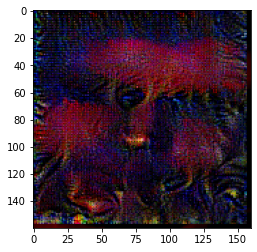

In [47]:
%%time
resnet.eval()

images, noise_matrix = pgd_attack(resnet, x, y, eps=5, alpha=5/255, iters=40)
y = y.to(device)
outputs = resnet(images)

_, predicted = torch.max(outputs.data, 1)


#imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True))

plt.imshow(np.transpose(utils.make_grid(images.detach().cpu(), padding=2, normalize=True),(1,2,0)))

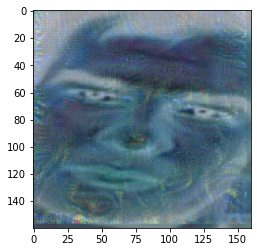

In [11]:
# Plot Noise Matrix


plt.imshow(np.transpose(utils.make_grid(noise_matrix.detach().cpu(), padding=2, normalize=True),(1,2,0)))

## Second version - DeepFool

In [39]:
import copy

def deepfool(image, net, num_classes=50, overshoot=0.02, max_iter=10):

    image = image.to(device)
    
    f_image = net.forward(image).data.cpu().numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.detach().cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = torch.tensor(pert_image[None, :],requires_grad=True)
    
    fs = net.forward(x[0])
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            
            #x.zero_grad()
            
            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        r_tot = torch.from_numpy(r_tot)
        pert_image = image + (1+overshoot)*r_tot.cuda()

        x = torch.tensor(pert_image, requires_grad=True)
        fs = net.forward(x[0])
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image

In [ ]:
resnet.eval()
r, loop_i, label_orig, label_pert, pert_image = deepfool(x, resnet, max_iter=50)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# Extract Noise as patch

In [27]:
frame = x[0].detach().cpu().numpy()
frame = np.transpose(frame, (1,2,0))
frame = cv2.normalize(src=frame, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) ## V.V.IMP!!

frame_patch_height, frame_patch_width, _ = frame.shape

result = face_mesh.process(frame)

In [13]:
location = 'Nose'
global_patch_width = 30
bd_image = cv2.imread("BD.jpeg")


for facial_landmarks in result.multi_face_landmarks:
    
    patch_width, patch_height, top_left = get_landmarks(location, frame_patch_width, frame_patch_height, global_patch_width, facial_landmarks)
    
    np_img = noise_matrix[0].detach().cpu().numpy()
    np_img = np.transpose(np_img, (1,2,0))
    
    reqd_matrix = np_img[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width]
    
    bd_image = cv2.resize(bd_image, (reqd_matrix.shape[1], reqd_matrix.shape[0]))
    
    noisy_patch = bd_image + bd_image * reqd_matrix
    noisy_patch = noisy_patch.clip(0, 255)
    
     # Adding the Band Aid Image
    bd_pic = cv2.resize(noisy_patch, (patch_width, patch_height))
    bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

    location_area = frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width]
    
    mask = mask.astype(np.uint8)
    bd_pic = bd_pic.astype(np.uint8)

    location_area_no_loc = cv2.bitwise_and(location_area, location_area, mask=mask)

    final_nose = cv2.add(location_area_no_loc, bd_pic)
    
    print(final_nose.shape)
    print(frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width].shape)

    frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] = frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] + final_nose

(30, 30, 3)
(30, 30, 3)


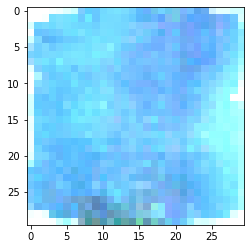

In [14]:
plt.imshow(final_nose)

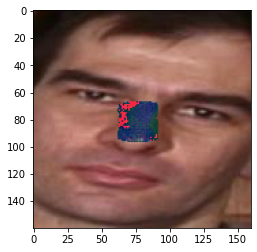

In [15]:
plt.imshow(frame)

## Second Version of DeepFool

# Prediction

In [16]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [29]:
aligned = []
x_aligned, prob = mtcnn(frame, return_prob=True)
aligned.append(x_aligned)

In [18]:
resnet.eval()              # REQUIRED for Inference or else you will get the BatchNorm 1 channel error

#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
dist, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy() 
print(dist, preds)
#print([dataset.idx_to_class[p] for p in preds])

tensor([10.0928], device='cuda:1', grad_fn=<MaxBackward0>) [0]


In [19]:
preds, y

(array([0]), tensor([0], device='cuda:1'))

In [52]:
y = resnet(faces)[0]
y

tensor([10.0928, -4.4931,  0.0348, -1.2792, -1.2632,  2.5453, -1.0912, -0.1835,
        -0.5438, -2.0922, -1.7599,  4.6072, -1.3343, -0.5439,  1.8573, -1.1729,
        -1.8883, -0.9836, -1.4493,  1.3722,  0.0889,  2.1956,  2.9945, -0.8716,
        -0.1040, -1.4029, -3.6348,  2.7359, -2.8840,  0.9360,  2.3338,  0.4485,
         0.0885, -0.0648,  1.3054,  1.0981, -1.1131,  0.7929,  0.7924, -1.2334,
        -3.3913, -0.4819,  0.3498, -2.9025, -1.8376, -1.5743,  0.5784, -0.8848,
         0.2754,  0.3288], device='cuda:1', grad_fn=<SelectBackward>)

In [53]:
len(y)

50

In [54]:
_, pre = torch.max(y, dim=0)
pre

tensor(0, device='cuda:1')